# 이미지 불러오기 

In [1]:
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('tcp'), Posix

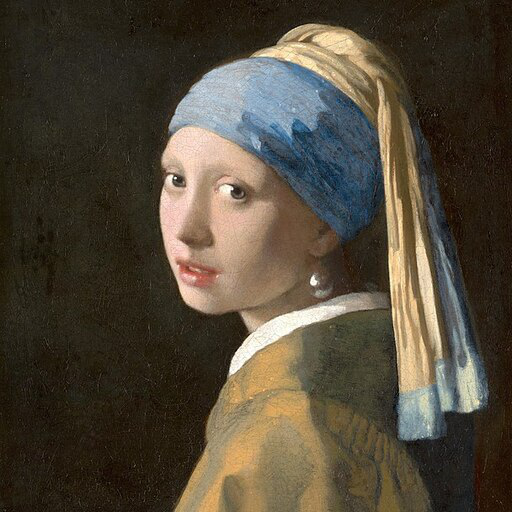

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 
torch.cuda.empty_cache()

image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

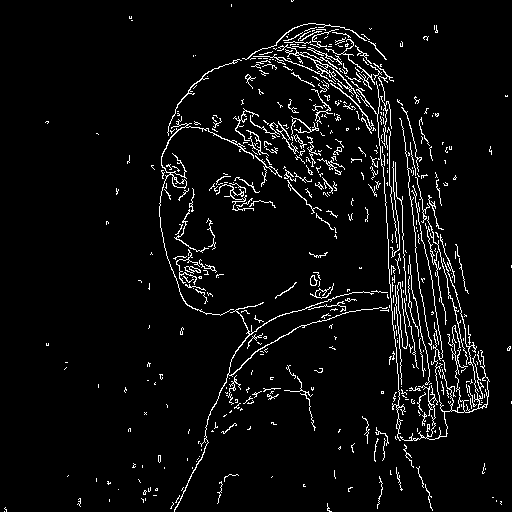

In [3]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

In [4]:
torch.cuda.empty_cache()

In [5]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

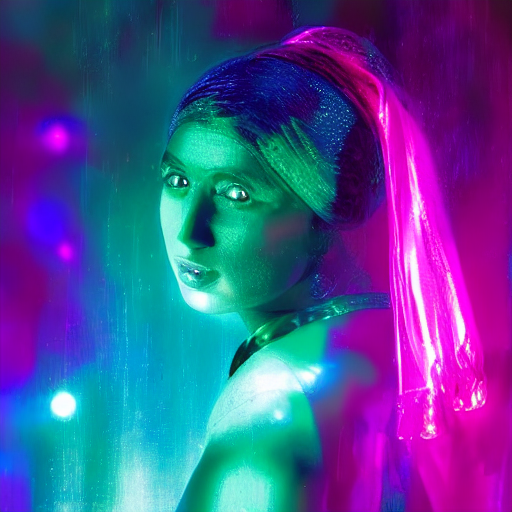

In [6]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

Token indices sequence length is longer than the specified maximum sequence length for this model (86 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ponder the intriguing combination of human and canine.']


  0%|          | 0/50 [00:00<?, ?it/s]

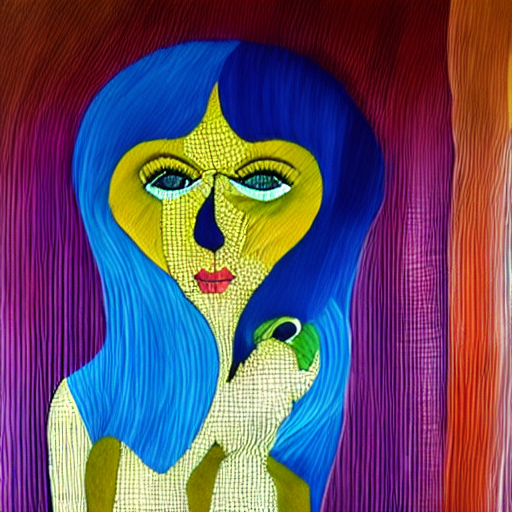

In [7]:
# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

prompt ="A human figure donning a dog mask is depicted in an indoor setting, gazing at the viewer in a surreal self-portrait. Inspired by the style of Frida Kahlo, the oil-on-canvas painting portrays the whimsical transformation with earthy tones and warm, subtle lighting. The high-detail artwork captures a sense of introspection and playfulness, inviting viewers to ponder the intriguing combination of human and canine."
negative_prompt ="Unconvincing dog mask, lack of resemblance, flat colors, awkward composition, stiff pose, disconnected expression, unrealistic lighting, mismatched proportions, lack of depth in the eyes, underwhelming texture in the mask, dull color palette, generic depiction, lack of Frida Kahlo's signature symbolism, lack of emotion, unnatural skin tones, uninspired background, absence of surreal elements, absence of self-reflective qualities."
# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt=prompt, 
    negative_prompt=negative_prompt,
    num_inference_steps=50, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_dog.png")  

# 생성된 이미지를 출력합니다. 
canny_image

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


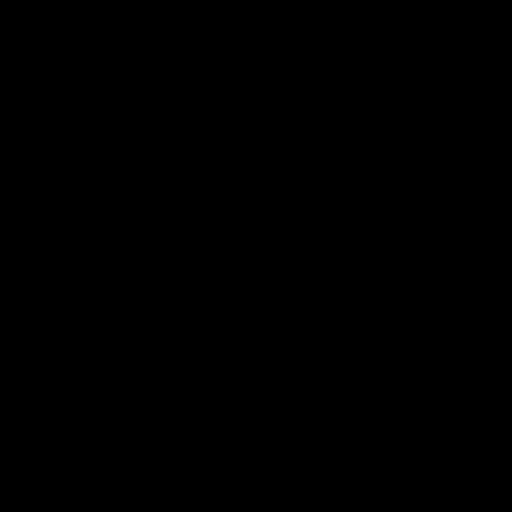

In [8]:
# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

prompt ="a werewolf with colorful lightst"

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt=prompt, 
    num_inference_steps=50, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_dog.png")  

# 생성된 이미지를 출력합니다. 
canny_image

# 인체 자세 감지

In [9]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

     |████████████████████████████████| 42 kB 331 kB/s             


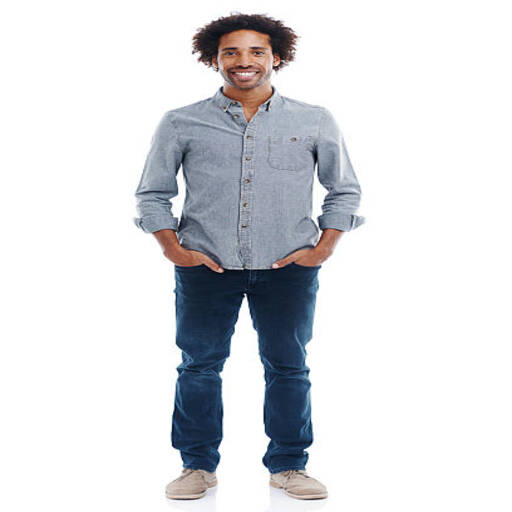

In [10]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


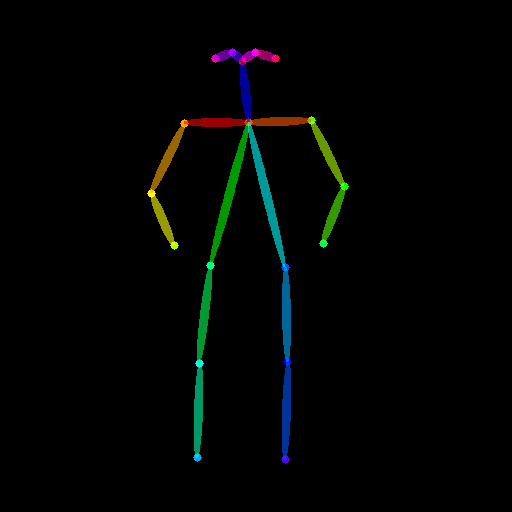

In [11]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [12]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

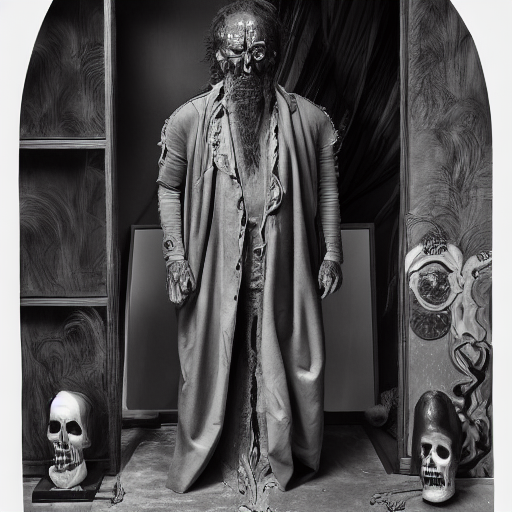

In [13]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(0)

#프롬프트를 작성합니다. 
prompt =  "A character study of a human figure possessing the face of a guinea pig, captured in a studio setting. The surreal artwork, reminiscent of Hieronymus Bosch's style, is rendered in monochrome tones through a detailed charcoal drawing. The focused, directional lighting accentuates the bizarre and intriguing nature of the facial transformation, inviting viewers to explore the depths of this unusual depiction."
negative_prompt =  "Unclear guinea pig features, lack of resemblance, inconsistent shading, flat expression, awkward composition, unnatural blending, stiff pose, lack of depth in the eyes, lack of texture in the guinea pig face, unconvincing monochrome palette, generic depiction, lack of surreal elements, absence of Hieronymus Bosch's signature symbolism, lack of emotion, uninspired background, lack of intricate details, disconnected facial features, lack of character, unrealistic proportions."

images = openpose_image

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(
    prompt=prompt, 
    negative_prompt = negative_prompt,
    num_inference_steps=50, 
    generator=generator, 
    image=images
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image1

  0%|          | 0/50 [00:00<?, ?it/s]

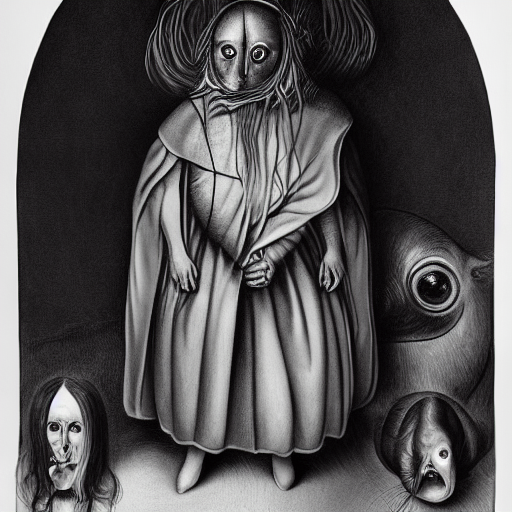

In [14]:

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(0)

#프롬프트를 작성합니다. 
prompt =  "A character study of a human figure possessing the face of a guinea pig, captured in a studio setting. The surreal artwork, reminiscent of Hieronymus Bosch's style, is rendered in monochrome tones through a detailed charcoal drawing. The focused, directional lighting accentuates the bizarre and intriguing nature of the facial transformation, inviting viewers to explore the depths of this unusual depiction."
negative_prompt =  "Unclear guinea pig features, lack of resemblance, inconsistent shading, flat expression, awkward composition, unnatural blending, stiff pose, lack of depth in the eyes, lack of texture in the guinea pig face, unconvincing monochrome palette, generic depiction, lack of surreal elements, absence of Hieronymus Bosch's signature symbolism, lack of emotion, uninspired background, lack of intricate details, disconnected facial features, lack of character, unrealistic proportions."

images = openpose_image

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(
    prompt=prompt, 
#     negative_prompt = negative_prompt,
    num_inference_steps=50, 
    generator=generator, 
    image=images
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image1

# 윤곽선 검출 + 인체 자세 감지

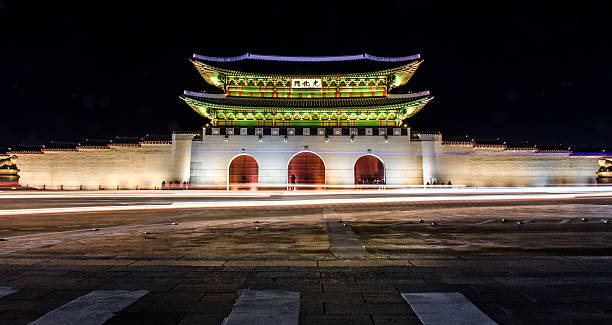

In [15]:
import cv2
# canny_image = load_image("https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAyMzA3MDhfMTUw%2FMDAxNjg4NzgwMTk0MjE2.Wl4uW-I3Gk6R6s7Lqv8HX9Az7UzkxNQ6NODd8GIawCMg.8R4AN1-CbP3lPJS-QSu-32sKGEX0pR2IRzZbElb0xnYg.PNG.7582su%2Fimage.png&type=sc960_832")
# canny_image = load_image("https://search.pstatic.net/common/?src=http%3A%2F%2Fimgnews.naver.net%2Fimage%2F015%2F2021%2F10%2F28%2F0004621594_003_20211028063701117.jpg&type=sc960_832")
canny_image = load_image(
    "https://media.istockphoto.com/id/475884494/ko/%EC%82%AC%EC%A7%84/%EA%B4%91%ED%99%94%EB%AC%B8-%EC%95%BC%EA%B0%84%EC%97%90%EB%A7%8C.jpg?s=612x612&w=0&k=20&c=TCBfFBHDHkcbCi8NCnjmkKD4dIeugrnsoILddUr9O08="
)

canny_image

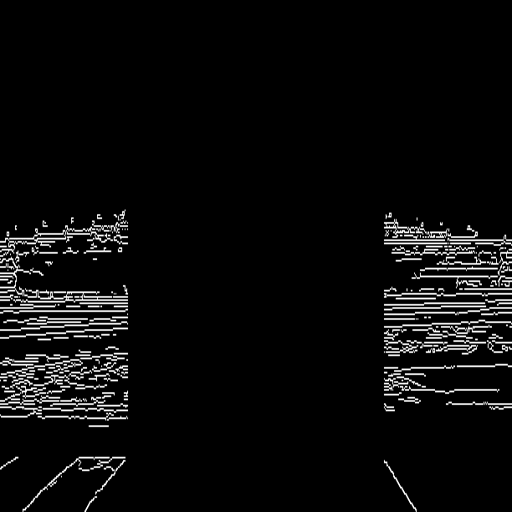

In [16]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image



#threshhold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. 
canny_image = np.array(canny_image)

canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)

canny_image = Image.fromarray(canny_image)
canny_image = canny_image.resize((512,512))
canny_image




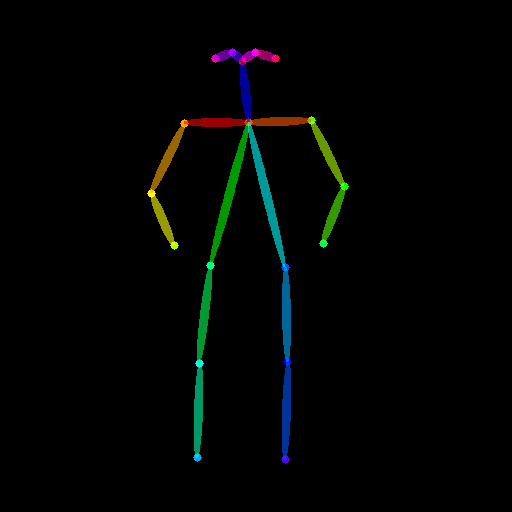

In [17]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다. 
# openpose_image =  load_image("https://search.pstatic.net/common/?src=http%3A%2F%2Fimgnews.naver.net%2Fimage%2F015%2F2021%2F10%2F28%2F0004621594_003_20211028063701117.jpg&type=sc960_832")
openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose_image = openpose(openpose_image)
openpose_image = openpose_image.resize((512,512))
openpose_image


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Token indices sequence length is longer than the specified maximum sequence length for this model (129 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ur of the metropolis in hyper - realistic 8 k resolution. the color scheme of electric blue, neon green, and deep purple adds an otherworldly ambiance to the composition, enhanced by the masterful use of neon - lit 3 d graphics and volumetric lighting.']


  0%|          | 0/25 [00:00<?, ?it/s]

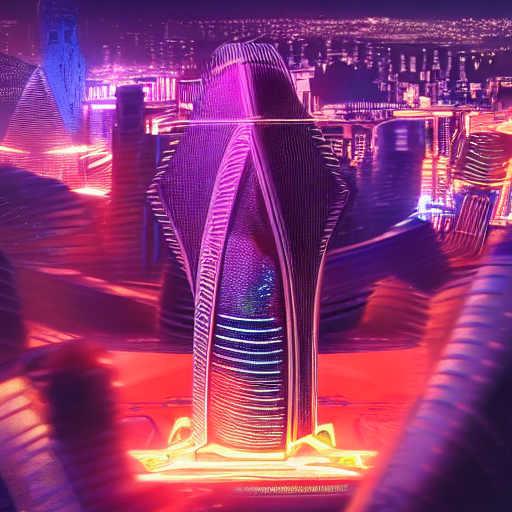

In [18]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnets = [canny_controlnet, openpose_controlnet]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt =  "A futuristic cityscape with an elder figure seated atop a monumental building, deeply lost in thought. The city sprawls beneath, its intricate holographic architecture creating a mesmerizing spectacle. The neon lights cast a vibrant glow, reflecting off the elder's wise expression. The scene is a fusion of cyberpunk and surrealism, realized through a stunning digital painting with intricate 3D details, capturing the grandeur of the metropolis in hyper-realistic 8K resolution. The color scheme of electric blue, neon green, and deep purple adds an otherworldly ambiance to the composition, enhanced by the masterful use of neon-lit 3D graphics and volumetric lighting."
# negative_prompt =  # [[YOUR CODE]]

# seed를 지정합니다. 
generator = torch.manual_seed(1)

images = [openpose_image, canny_image]

# 이미지를 생성합니다. 
image = pipe(
    prompt,
    images,
    num_inference_steps=25,
    generator=generator
).images[0]

# 생성된 이미지를 저장합니다.
image.save("/aiffel/aiffel/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.  
image

In [19]:
torch.cuda.empty_cache()

In [20]:
torch.cuda.memory_allocated()

9996827136

In [21]:
torch.cuda.empty_cache()